Modified from tutorial: https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc

In [56]:
import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
import random

In [57]:
images_path = Path("images")
annot_path = Path("annotations")

In [145]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text.replace("rpi footage/",""))
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        try:
            anno['class'] = root.find("./object/name").text
            anno['xmin'] = int(float(root.find("./object/bndbox/xmin").text))
            anno['ymin'] = int(float(root.find("./object/bndbox/ymin").text))
            anno['xmax'] = int(float(root.find("./object/bndbox/xmax").text))
            anno['ymax'] = int(float(root.find("./object/bndbox/ymax").text))
        except AttributeError:
            anno['class'] = "background"
            anno['xmin'] = 0
            anno['ymin'] = 0
            anno['xmax'] = 0
            anno['ymax'] = 0

        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [146]:
df_train = generate_train_df(annot_path)

In [147]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\20230504-155333.jpg,320,240,Person,145,27,242,153
1,images\20230504-155334.jpg,320,240,Person,180,142,259,236
2,images\20230504-155336.jpg,320,240,Person,194,189,262,240
3,images\20230504-155337.jpg,320,240,Person,210,214,272,240
4,images\20230504-155338.jpg,320,240,Person,214,214,272,240
...,...,...,...,...,...,...,...,...
326,images\20230511-164048.jpg,320,240,background,0,0,0,0
327,images\20230511-164049.jpg,320,240,background,0,0,0,0
328,images\20230511-164053.jpg,320,240,background,0,0,0,0
329,images\20230511-164054.jpg,320,240,background,0,0,0,0


In [148]:
#label encode target
class_dict = {'Person': 1, 'background': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [149]:
print(df_train.shape)
df_train.head()

(331, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\20230504-155333.jpg,320,240,1,145,27,242,153
1,images\20230504-155334.jpg,320,240,1,180,142,259,236
2,images\20230504-155336.jpg,320,240,1,194,189,262,240
3,images\20230504-155337.jpg,320,240,1,210,214,272,240
4,images\20230504-155338.jpg,320,240,1,214,214,272,240


## Resizing images and bounding boxes

In [150]:
import cv2

In [151]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [152]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [153]:
# def resize_image_bb(read_path,write_path,bb,sz):
#     """Resize an image and its bounding box and write image to new path"""
#     im = read_image(read_path)
#     im_resized = cv2.resize(im, (int(1.49*sz), sz))
#     Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
#     new_path = str(write_path/read_path.parts[-1])
#     cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
#     return new_path, mask_to_bb(Y_resized)

In [154]:
# #Populating Training DF with new paths and bounding boxes
# new_paths = []
# new_bbs = []
# train_path_resized = Path('./rpifootage')
# for index, row in df_train.iterrows():
#     new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
#     new_paths.append(new_path)
#     new_bbs.append(new_bb)
# df_train['new_path'] = new_paths
# df_train['new_bb'] = new_bbs

In [155]:
bbs = []
for index, row in df_train.iterrows():
    bbs.append(np.array(row.values[-4:]))
df_train['bb'] = bbs

In [156]:
df_train.values[58][0]

WindowsPath('images/20230509-145327.jpg')

In [157]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(240, 320, 3)


In [158]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([134., 136., 169., 155.], dtype=float32)

### Sample Img

In [159]:
import matplotlib.pyplot as plt

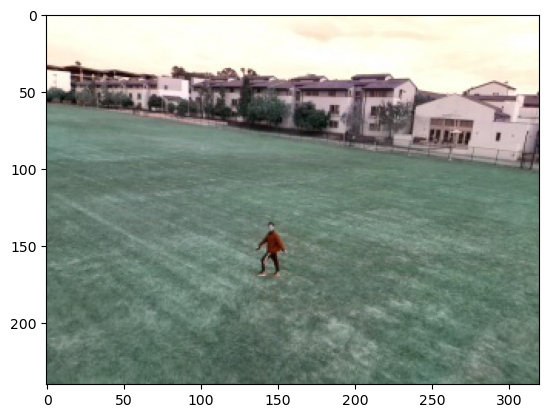

In [160]:
plt.imshow(im)

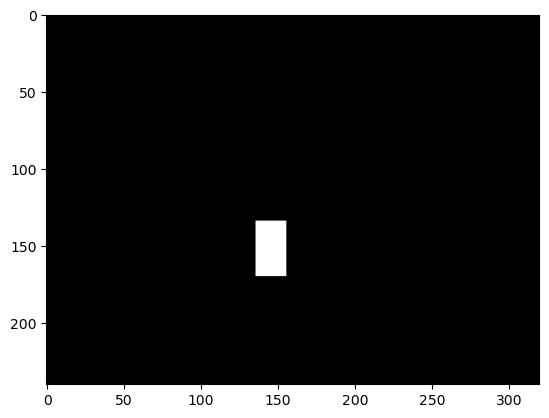

In [161]:
plt.imshow(Y, cmap='gray')

## Data Augmentation

In [162]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [163]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [164]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [165]:
df_train.values[68]

array([WindowsPath('images/20230509-145337.jpg'), '320', '240', 1, 189,
       87, 196, 101, array([189, 87, 196, 101], dtype=object)],
      dtype=object)

In [166]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax,bb
0,images\20230504-155333.jpg,320,240,1,145,27,242,153,"[145, 27, 242, 153]"
1,images\20230504-155334.jpg,320,240,1,180,142,259,236,"[180, 142, 259, 236]"
2,images\20230504-155336.jpg,320,240,1,194,189,262,240,"[194, 189, 262, 240]"
3,images\20230504-155337.jpg,320,240,1,210,214,272,240,"[210, 214, 272, 240]"
4,images\20230504-155338.jpg,320,240,1,214,214,272,240,"[214, 214, 272, 240]"
...,...,...,...,...,...,...,...,...,...
326,images\20230511-164048.jpg,320,240,0,0,0,0,0,"[0, 0, 0, 0]"
327,images\20230511-164049.jpg,320,240,0,0,0,0,0,"[0, 0, 0, 0]"
328,images\20230511-164053.jpg,320,240,0,0,0,0,0,"[0, 0, 0, 0]"
329,images\20230511-164054.jpg,320,240,0,0,0,0,0,"[0, 0, 0, 0]"


[WindowsPath('images/20230504-155333.jpg') '320' '240' 1 145 27 242 153
 array([145, 27, 242, 153], dtype=object)]


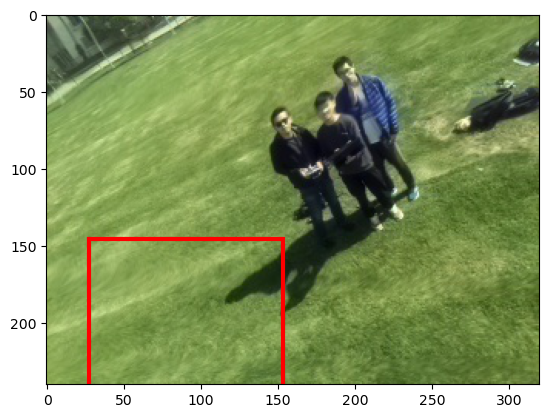

In [170]:
#original
im = cv2.imread(str(df_train.values[0][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[0][8])
print(df_train.values[0])

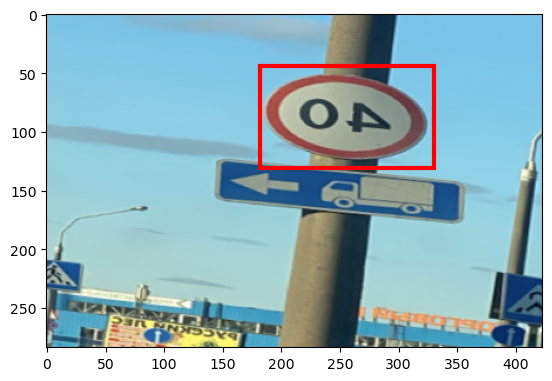

In [24]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

### Train - Validation split

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from sklearn.model_selection import train_test_split

In [26]:
df_train = df_train.reset_index()

In [27]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

### Dataset

In [29]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [30]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [31]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [32]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Model

In [33]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

### Training

In [34]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [35]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [36]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [37]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

/home/biggergig/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/biggergig/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.076 val_loss 37.422 val_acc 0.580
train_loss 1.255 val_loss 1.078 val_acc 0.682
train_loss 0.970 val_loss 0.899 val_acc 0.773
train_loss 1.020 val_loss 1.819 val_acc 0.778
train_loss 0.965 val_loss 1.231 val_acc 0.716
train_loss 1.011 val_loss 0.961 val_acc 0.739
train_loss 0.997 val_loss 47.561 val_acc 0.795
train_loss 0.939 val_loss 0.873 val_acc 0.795
train_loss 0.985 val_loss 0.909 val_acc 0.795
train_loss 1.019 val_loss 0.960 val_acc 0.801
train_loss 0.993 val_loss 1.126 val_acc 0.773
train_loss 1.109 val_loss 0.915 val_acc 0.790
train_loss 1.296 val_loss 2.232 val_acc 0.773
train_loss 1.051 val_loss 1.727 val_acc 0.778
train_loss 1.071 val_loss 1.240 val_acc 0.710


1.0708117804751758

In [39]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.928 val_loss 0.919 val_acc 0.767
train_loss 0.845 val_loss 0.834 val_acc 0.790
train_loss 0.866 val_loss 0.832 val_acc 0.784
train_loss 0.835 val_loss 0.847 val_acc 0.784
train_loss 0.853 val_loss 0.827 val_acc 0.778
train_loss 0.819 val_loss 0.804 val_acc 0.795
train_loss 0.835 val_loss 0.814 val_acc 0.790
train_loss 0.824 val_loss 0.805 val_acc 0.807
train_loss 0.831 val_loss 0.823 val_acc 0.790
train_loss 0.810 val_loss 0.807 val_acc 0.795


0.8096927787029794